<a href="https://colab.research.google.com/github/bereml/iap/blob/master/libretas/1c_reglin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresión lineal

Curso: [Introducción al Aprendizaje Profundo](http://turing.iimas.unam.mx/~ricardoml/course/iap/). Profesores: [Bere](https://turing.iimas.unam.mx/~bereml/) y [Ricardo](https://turing.iimas.unam.mx/~ricardoml/) Montalvo Lezama.

---
---

En esta libreta implementaremos el modelo regresión lineal sobre un conjunto de datos de calificaciones, lo que deseamos predecir es que calificación tendrá el alumno en un examen. El conjunto de datos posee dos atributos entrada: la calificación que obtuvo en un examen previo y el número de horas que estudio el alumno para presentar el examen. En este ejemplo consideraremos únicamente un atributo de entrada, el número de horas de estudio.

![xkcd-linreg](https://imgs.xkcd.com/comics/linear_regression.png)
<div> https://xkcd.com/1725/ </div>

## 1 Preparación

### 1.1 Bibliotecas

In [1]:
# sistema de archivos
import os

# gráficas
import matplotlib.pyplot as plt
# csv
import pandas as pd
# redes neuronales
import torch

### 1.2 Auxiliares

In [2]:
URL = 'https://raw.githubusercontent.com/bereml/iap/master/datos/califs.csv'
base_dir = '../datos'
filename = 'califs.csv'
filepath = os.path.join(base_dir, filename)

## 2 Datos

Descargamos los datos.

In [3]:
! wget -nc {URL} -O {filepath}

File '../datos/califs.csv' already there; not retrieving.


Utilizamos para la lectura del csv e imprimimos los primeros 5 ejemplos.

In [4]:
df = pd.read_csv(filepath)
df.head(5)

,prev,horas,calif
0,5.6,8.2,5.1
1,6.7,9.3,5.9
2,5.1,10.0,5.4
3,5.7,10.4,6.5
4,7.1,10.4,6.7


Obtengamos el atributo y la salida:

In [5]:
x = torch.tensor(df.iloc[:, 1].values)
x = x.view(-1, 1).type(torch.float32)
print(x.shape)
x[:5]

torch.Size([50, 1])


tensor([[ 8.2000],
        [ 9.3000],
        [10.0000],
        [10.4000],
        [10.4000]])

In [6]:
y_true = torch.tensor(df.iloc[:, 2].values)
y_true = y_true.view(-1, 1).type(torch.float32)
print(y_true.shape)
y_true[:5]

torch.Size([50, 1])


tensor([[5.1000],
        [5.9000],
        [5.4000],
        [6.5000],
        [6.7000]])

In [7]:
# número de ejemplos y atributos
m, d = x.shape
m, d

(50, 1)

Grafiquemos para tener una idea de la distribución de los datos:

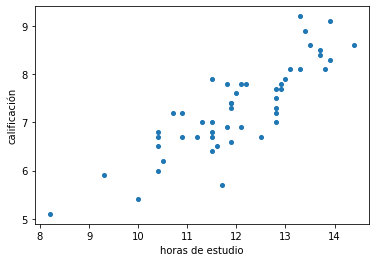

In [8]:
plt.plot(x.view(-1).numpy(), y_true.view(-1).numpy(), 
         '.', color='tab:blue', markersize=8)
plt.xlabel('horas de estudio')
plt.ylabel('calificación')
plt.show()

## 3 Hipótesis

Recordemos que dado un conjunto de ejemplos con atributos ($x_1, \dots, x_d$) y salidas $y$, la hipótesis de regresión lineal considerando un plano está dada por:

$$\hat{y} = w_1 x_1 + \dots + w_d x_d + b$$

donde $w_i$ y $b$ son pesos y sesgo (parámetros) del modelo y $\hat{y}$ la salida predicha. Podemos expresar la hipótesis en su forma vectorial como:

$$\hat{y} = w x + b$$

Nuestro trabajo consiste en estimar (aprender) los parámetros $w_i$ y $b$. Por el momento supongamos que proponemos valores para los parámetros y hagamos inferencia:

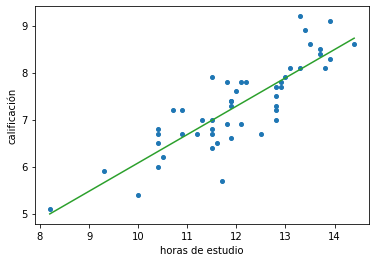

In [9]:
# parámetros que nos regalo el oráculo
w = torch.tensor([[0.6030]])
b = torch.tensor([0.0496])

# inferencia
y_pred = x @ w + b

# gráfica
plt.plot(x.view(-1).numpy(), y_true.view(-1).numpy(), 
         '.', color='tab:blue', markersize=8)
plt.plot(x.view(-1).numpy(), y_pred.view(-1).numpy(), 
         '-', color='tab:green', markersize=8)
plt.xlabel('horas de estudio')
plt.ylabel('calificación')
plt.show()

## 4 Función de pérdida

La pérdida para este modelo es el error cuadrático medio y queda expresado de la siguiente manera:

$$ J(w, b) = \frac{1}{2m}  \sum_{i=1}^{m}{(\hat{y}^{(i)} - y^{(i)})^2} $$

en su forma vectorial:

$$ J(w, b) = \frac{1}{2m} (\hat{y} - y)^T (\hat{y} - y) $$

Para los parámetros propuestos, la pérdida se puede implementar como:

In [10]:
loss = (y_pred - y_true).T @ (y_pred - y_true) / (2 * m)
loss

tensor([[0.1176]])

## 5 Descenso por gradiente

![graddes](https://ml-cheatsheet.readthedocs.io/en/latest/_images/gradient_descent_demystified.png)
<div> https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html </div>
&nbsp;

El algoritmo del gradiente descendente se basa en el gradiente de la pérdida respecto de los parámetros:

$$\frac{\partial J(w_j)}{\partial w_j} = \frac{1}{m} \sum_{i=1}^{m}{x^{(i)}_j(\hat{y}^{(i)} - y^{(i)})}$$

$$\frac{\partial J(b)}{\partial b} = \frac{1}{m} \sum_{i=1}^{m}{(\hat{y}^{(i)} - y^{(i)})}$$

en su forma vectorial:

$$\Delta J(w) = \frac{1}{m} x^T (\hat{y} - y)$$

$$\Delta J(b) = \frac{1}{m} \sum_{i=1}^{m}{(\hat{y} - y)^{(i)}}$$

Para los parámetros propuestos, el computo gradiente se puede implementar como:

In [11]:
grad_w = (x.T @ (y_pred - y_true)) / m
grad_b = (y_pred - y_true).sum() / m
grad_w, grad_b

(tensor([[-0.0390]]), tensor(-0.0028))

## 6 Entrenamiento

Ahora implementemos todo en una función:

In [12]:
def train(x, y_true, alpha=0.01, steps=10):
    """Fits linear regression."""

    # ejemplos, atributos
    m, d = x.shape

    # inicialización de parámetros
    w = torch.zeros(d, 1)
    b = torch.zeros(1)

    # histórico de pérdidas
    loss_hist = []

    # ciclo de entrenamiento
    for i in range(steps):

        # cómputo de la hipótesis
        y_pred = x @ w + b

        # cómputo de la pérdida
        loss = (y_pred - y_true).T @ (y_pred - y_true) / (2 * m)

        # cómputo del gradiente
        grad_w = (x.T @ (y_pred - y_true)) / m
        grad_b = (y_pred - y_true).sum() / m

        # actualización de parámetros
        w = w - alpha * grad_w
        b = b - alpha * grad_b

        # histórico de pérdida
        loss_hist.append(loss)

    return w, b, loss_hist

Entrenemos un modelo:

In [13]:
w, b, loss_hist = train(x, y_true)
w, b

(tensor([[0.6030]]), tensor([0.0496]))

Grafiquemos la evolución de la pérdida:

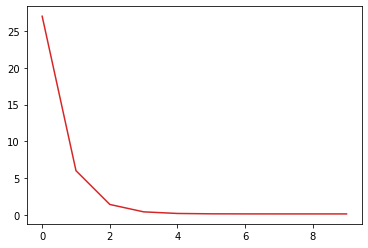

In [14]:
plt.figure()
plt.plot(range(len(loss_hist)), loss_hist, color='tab:red')
plt.show()

## 7 Discusión

* ¿De qué otra forma podemos inicilizar los parámetros?
* ¿Cómo influye la tasa de aprendizaje?
* ¿Cómo elejimos el número de pasos de entrenamiento?